# Advantage Actor-Critic (A2C)


https://arxiv.org/pdf/1506.02438.pdf

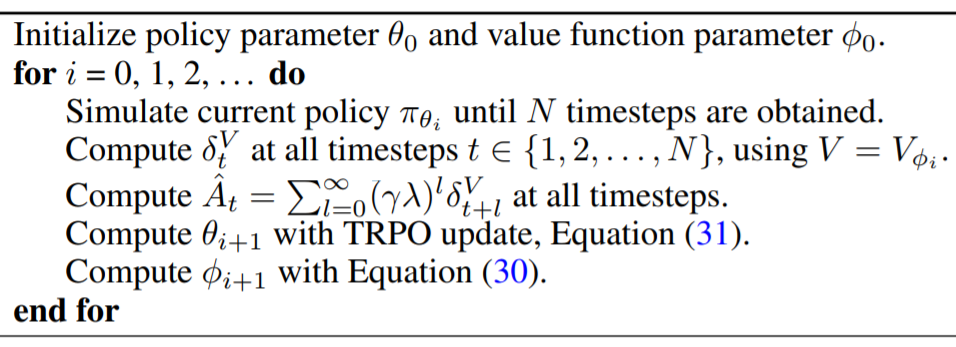

There is no TRPO update here, just advantage and MSE

In [1]:
import numpy as np
import gym
import tensorflow as tf
import scipy
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

critic_learning_rate = 1e-4
actor_learning_rate = 1e-4
epochs_number = 200000
batch_size = 128
replay_buffer_size = batch_size
l2_regularization = 0

discount_factor = 0.98
lambda_factor = 0.96

env_name = 'InvertedDoublePendulum-v2'
environments_count = 40

# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [3]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [4]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

        action_logprob = gaussian_loglikelihood(self.action_ph, mu, log_std)

        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = -tf.reduce_mean(action_logprob * self.weight_ph) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
        l1 = tf.layers.dense(self.state_ph, units=20, activation=tf.nn.relu)
        output_linear = tf.layers.dense(l1, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
        #action_op = tf.expand_dims(tf.constant(1), axis=0)

        # Training
        output_log = tf.nn.log_softmax(output_linear)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        self.loss = -tf.reduce_mean(responsible_output_log * self.weight_ph)

        optimizer = tf.train.AdamOptimizer(learning_rate=actor_learning_rate)
        self.update_op = optimizer.minimize(self.loss)

    
class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)
        print(self.value_op)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.loss)
    
actor = ActorNetworkContinuous()
critic = CriticNetwork()

W0721 11:51:59.364293  6464 deprecation.py:323] From <ipython-input-4-f1ca94053e9b>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0721 11:51:59.370275  6464 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0721 11:51:59.678484  6464 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [6]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
np.hstack((a, [[11], [12], [13]]))

array([[ 1,  2,  3, 11],
       [ 4,  5,  6, 12],
       [ 7,  8,  9, 13]])

In [7]:
def f(x):
    x[0] = 6

In [8]:
a = np.array([1, 2, 3])
f(a)
print(a)

[6 2 3]


In [9]:
def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

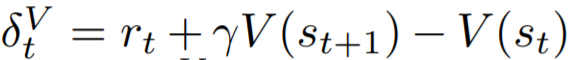

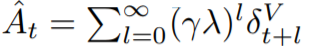

In [10]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [11]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    
    # [state, action, advantage, discounted reward-to-go]
    replay_buffer = np.empty((0,4), np.float32)
    
    # [state, action, reward] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(actor.action_op, feed_dict={actor.state_ph: observations})
#             actions = [envs.action_space.sample() for i in range(envs_number)]
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum())
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage

                discounted_reward_to_go = discount_cumsum(rewards_trajectory, coef=discount_factor)

                
                rollout = np.hstack((rollouts[i], np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 3))
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([-0.34925485,  0.63764711, -0.69688357,  0.77032861,  0.71718428,
       -4.71093218,  8.08056532, -5.63737371,  0.        ,  0.        ,
        0.        ]),
        array([-0.5481769], dtype=float32), 9.109905034303665,
        8.654705047607422],
       [array([-0.15831127,  0.337646  , -0.36655009,  0.94127317,  0.93039832,
       -2.59978172,  5.74834127, -6.46857777,  0.        ,  0.        ,
        0.        ]),
        array([-1.3537807], dtype=float32), 17.348123581004142,
        17.320314769744872],
       [array([ 0.03771942,  0.04181484,  0.04981656,  0.99912538,  0.99875838,
        0.04875545, -0.03076512, -0.10008503,  0.        ,  0.        ,
        0.        ]),
        array([-0.54496264], dtype=float32), 47.68416581024468,
        51.87247891877679],
       [array([-0.05685204,  0.11086813, -0.09895028,  0.99383513,  0.99509238,
       -1.42838109,  3.44305803, -4.15438085,  0.        ,  0.        ,
        0.        ]),
        array([-0.5329622], 

## Train agent 

In [12]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}

In [18]:

max_value = 160

In [ ]:
from tqdm import tqdm_notebook

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

saver = tf.train.Saver()

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']


    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-reward-{value}.ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value

    _, actor_loss = sess.run([actor.update_op, actor.loss], feed_dict={
                                                actor.state_ph: np.array(batch[:, 0].tolist()),
                                                actor.action_ph: np.array(batch[:, 1].tolist()),
                                                actor.weight_ph: batch[:, 2]})

    _, critic_loss = sess.run([critic.update_op, critic.loss], feed_dict={
                                                critic.state_ph: np.array(batch[:, 0].tolist()),
                                                critic.value_ph: batch[:, 3]})
    
#     history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
#     history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    
    history['critic_loss'].append(critic_loss)
    history['actor_loss'].append(actor_loss)



Charging generators


Model saved in path: ./models/InvertedDoublePendulum-v2-reward-9346.ckpt


Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


## Plot results

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

Text(0.5, 0.98, 'InvertedDoublePendulum-v2')

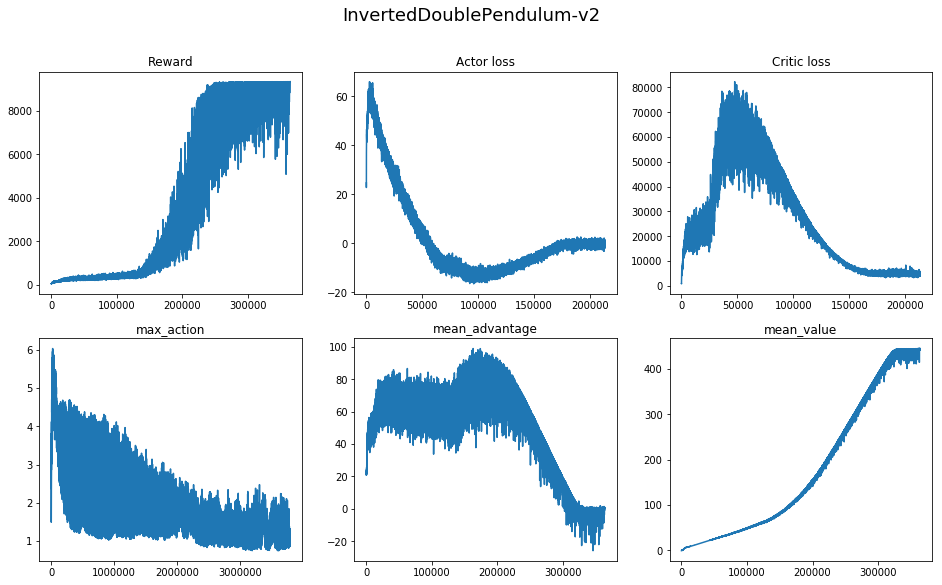

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

# plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


# parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
# plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name, fontsize=18)

# plt.savefig(f'logs/{env_name}')

## Our agent

In [8]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])

    print('h', rewards, actions[0])


    if dones:
        observations = env.reset()
        print('Done')


Creating window glfw
h 9.356431734019855 [-0.00376612]
h 9.348904182684475 [-0.23213938]
h 9.357234618424238 [0.19057246]
h 9.300427778910384 [0.57327163]
h 9.350644404034455 [-0.67929703]
h 9.34834503477688 [-0.13670698]
h 9.348072611512288 [0.35042447]
h 9.325853186939339 [-0.6129749]
h 9.333131119323193 [0.72655237]
h 9.345810278659387 [-0.5940251]
h 9.305341994879074 [0.7115585]
h 9.343724893160791 [-0.8071686]
h 9.357716202800097 [0.15500015]
h 9.351178763758824 [-0.21867697]
h 9.346554463327802 [-0.0363539]
h 9.33427123860373 [0.63622975]
h 9.35528248347825 [-0.45662817]
h 9.32700882240521 [-0.20251314]
h 9.312950888903327 [0.9270895]
h 9.34284373091565 [-0.14954732]
h 9.354022912172486 [-0.4565086]
h 9.358341917067678 [0.14743075]
h 9.356205923664692 [-0.14502826]
h 9.355997732207484 [0.03302896]
h 9.351492337136964 [-0.04299107]
h 9.308320072283305 [-0.27421376]
h 9.332291942107954 [0.79484075]
h 9.343409101903438 [-0.15713738]
h 9.338823183003067 [0.39489365]
h 9.3542560819571

h 9.354628391616949 [0.3459172]
h 9.353956242217166 [-0.34020594]
h 9.351296067634433 [-0.01940915]
h 9.357502476273654 [0.25477663]
h 9.355835485421823 [0.13936423]
h 9.358854546539856 [-0.03718371]
h 9.358843917105846 [0.02843984]
h 9.35951337711828 [-0.02918885]
h 9.359175677644687 [-0.10890121]
h 9.33462408366847 [-0.2780197]
h 9.305146139239524 [0.89520437]
h 9.354394816375633 [-0.6744146]
h 9.35730911727948 [0.03057991]
h 9.330471349353635 [0.47639263]
h 9.35643201965037 [-0.47856465]
h 9.339495540974802 [-0.3080122]
h 9.348839901225844 [0.08880329]
h 9.31335687447588 [0.7328497]
h 9.358853112211614 [-0.4798215]
h 9.356818367995524 [-0.15904601]
h 9.35652228821622 [-0.03401861]
h 9.358274369011397 [0.064349]
h 9.357837469204227 [0.04789079]
h 9.357143938127146 [0.05507496]
h 9.333766554099466 [0.4502446]
h 9.359174279546586 [-0.40083626]
h 9.35905637946046 [-0.02249357]
h 9.351326356570695 [0.25575235]
h 9.29430304675664 [-0.77010405]
h 9.326299693472055 [1.0287179]
h 9.357115627

h 9.34315046563041 [-0.24628976]
h 9.346581571190615 [0.148105]
h 9.341750072088042 [0.11715637]
h 9.328596631970022 [0.5789709]
h 9.352245525765653 [-0.18923543]
h 9.354480128641603 [0.01467557]
h 9.355415541146371 [0.09158406]
h 9.355143274892507 [0.0709753]
h 9.357004349846738 [-0.22147976]
h 9.357193606559624 [0.19801351]
h 9.354519082415596 [0.02669115]
h 9.325722178226282 [-0.5822352]
h 9.357251164509941 [0.50910604]
h 9.358954653177456 [-0.022693]
h 9.355270312023924 [-0.18390335]
h 9.358488995611445 [0.21953575]
h 9.356562015014866 [0.07047283]
h 9.356171015251071 [-0.02451825]
h 9.346412686118828 [0.07531983]
h 9.350800154246848 [-0.23235583]
h 9.331356704871261 [-0.48241678]
h 9.355247826001552 [0.3860057]
h 9.332805207774786 [-0.45889807]
h 9.337443514484828 [0.08471245]
h 9.313138642336611 [0.85786724]
h 9.3083033946537 [0.03756329]
h 9.34605028730806 [-0.74556655]
h 9.354600039383591 [0.07806295]
h 9.353189814747312 [-0.156498]
h 9.32095018447306 [-0.31532884]
h 9.31728480

h 9.349283336229446 [-0.00266867]
h 9.338026088964975 [0.5318418]
h 9.347292266181377 [-0.44570935]
h 9.289741121862285 [0.8369597]
h 9.346375884726749 [-0.83736414]
h 9.35979789627573 [0.2270405]
h 9.355947932861403 [-0.12995163]
h 9.35182058251069 [0.3415592]
h 9.34531582700942 [-0.45585042]
h 9.356506206133073 [0.39827588]
h 9.352926340774427 [0.06240338]
h 9.340234461279847 [0.06966023]
h 9.312720366987884 [-0.8101161]
h 9.357873448608347 [0.45616758]
h 9.354222250514681 [-0.14061783]
h 9.344599999368231 [0.3877591]
h 9.354191619975683 [-0.33265734]
h 9.337728097513644 [0.32617235]
h 9.347434531891766 [-0.45215428]
h 9.34293323203222 [0.2303055]
h 9.346086655905557 [-0.3630597]
h 9.337121864941976 [-0.23885304]
h 9.3510811914816 [0.3933538]
h 9.343505012188972 [-0.3946997]
h 9.327639878509967 [0.616497]
h 9.354293500899697 [-0.46797675]
h 9.348356565916868 [-0.18048091]
h 9.35815402913123 [0.18063983]
h 9.358505025769093 [0.0313349]
h 9.357672514788334 [-0.02358474]
h 9.35679488102

h 9.358917539736346 [0.4734307]
h 9.349961009224158 [0.19437401]
h 9.354477996972307 [-0.38051012]
h 9.355017519701805 [0.30750605]
h 9.34510298265472 [-0.4097133]
h 9.335562766032757 [0.6118516]
h 9.34771426863117 [-0.57266897]
h 9.357542037502563 [0.2046613]
h 9.351484013781704 [-0.07632332]
h 9.344871298756246 [0.43864942]
h 9.355205958024115 [-0.30153713]
h 9.342432018494852 [-0.10909756]
h 9.352968550898506 [0.36706686]
h 9.336566394193703 [0.3627823]
h 9.358799694792955 [-0.2321466]
h 9.291009007383032 [0.46700084]
h 9.34270234723492 [-0.91361535]
h 9.290269983570964 [-0.4880579]
h 9.352939951536545 [0.7414944]
h 9.354888775813892 [-0.32320422]
Pressed ESC
Quitting.


NameError: name 'exit' is not defined

## Random agent

In [ ]:
observations = env.reset()
rewards_sum = 0


for i in range(10000000):
    env.render()
    actions = [[np.random.randint(2) - 1 for i in range(action_space)] for i in range(1000)]
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[i])
    print(rewards)
    rewards_sum += rewards
    
    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [7]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/InvertedDoublePendulum-v2-reward-9346.ckpt")

W0721 11:52:10.074585  6464 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [ ]:
d = 20
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], d)
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], d)
q_table = np.zeros((d, d))

for i in range(len(x)):
    for j in range(len(y)):
        q_table[i][j] = sess.run(critic.value_op, feed_dict={critic.state_ph: [[x[i], y[j]]]})[0]


In [ ]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')


# Make data
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], q_table.shape[0])
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], q_table.shape[1])
z = q_table


# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X position', fontsize=20)
ax.set_ylabel('Velocity', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)